# Data Preparation 

In [191]:
# load packages

import math
%matplotlib inline

import numpy as np
import pandas as pd
import calendar

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import ensemble, metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from mpl_toolkits import mplot3d

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import pairwise_distances_argmin

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from kmodes.kmodes import KModes

import time

In [193]:
# load dataset 

Chicago_Crimes_2005_to_2007 = pd.read_csv("crimes-in-chicago/Chicago_Crimes_2005_to_2007.csv", usecols = range(23))
Chicago_Crimes_2008_to_2011 = pd.read_csv("crimes-in-chicago/Chicago_Crimes_2008_to_2011.csv", usecols = range(23))
Chicago_Crimes_2012_to_2017 = pd.read_csv("crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv", usecols = range(23))

# merge data 
Chicago_Crimes_2005_to_2017 = pd.concat([Chicago_Crimes_2005_to_2007, Chicago_Crimes_2008_to_2011, Chicago_Crimes_2012_to_2017])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [195]:
# filter the dataset by years and export data from 2007 to 2017

Chicago_Crimes_2005_to_2017.head(20)
print(Chicago_Crimes_2005_to_2017.Year.unique())
Chicago_Crimes_2007_to_2017 = Chicago_Crimes_2005_to_2017.loc[(Chicago_Crimes_2005_to_2017['Year'] >= 2007) 
                                                              & (Chicago_Crimes_2005_to_2017['Year'] <= 2017)]
print(Chicago_Crimes_2007_to_2017.Year.unique())

# store the new DataFrame to a csv file for later use.
Chicago_Crimes_2007_to_2017.to_csv("Chicago_Crimes_2007_to_2017.csv",index=False)

[2006 2005 2007 2008 2009 2011 2010 2016 2015 2012 2014 2013 2017]
[2007 2008 2009 2011 2010 2016 2015 2012 2014 2013 2017]


In [224]:
# load data from 2007 to 2017
df = pd.read_csv("Chicago_Crimes_2007_to_2017.csv")

# check for features 
print(df.columns.values)

# drop unnecessary features, col 0
df.drop(df.columns[0], axis = 1, inplace = True)
print(df.dtypes)
print(df.shape) # (4767274, 22), 22 features 

# removing unneeded features
df.drop(['Block', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0' 'ID' 'Case Number' 'Date' 'Block' 'IUCR' 'Primary Type'
 'Description' 'Location Description' 'Arrest' 'Domestic' 'Beat'
 'District' 'Ward' 'Community Area' 'FBI Code' 'X Coordinate'
 'Y Coordinate' 'Year' 'Updated On' 'Latitude' 'Longitude' 'Location']
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude                object
Location                 object
dtype: object
(4767274, 22)


In [225]:
# check uniqueness of ID
df['ID'].is_unique #no unique, cases being recorded multiple times 

False

In [226]:
# return only one record per case by removing duplicated rows 
# ex: df[df['ID'] == 7781132]; 7815319, 7781132, 6023200  

print(len(df.ID.unique())) #3434853, but we have 4767274 rows 
df.drop_duplicates(keep = 'first', inplace = True) #remove duplicates 

# drop Case number, we are using ID as the primary key
df.drop(['Case Number'], axis = 1, inplace = True)
df.reset_index(inplace = True)

print(df.shape) #(3434853, 15) #matched 

3434853
(3434853, 15)


In [227]:
# check for missing values

df.isna().any() # Location Description, District, Ward, Community Area

index                   False
ID                      False
Date                    False
IUCR                    False
Primary Type            False
Description             False
Location Description     True
Arrest                  False
Domestic                False
Beat                    False
District                 True
Ward                     True
Community Area           True
FBI Code                False
Year                    False
dtype: bool

In [228]:
# Replace null values with 'Other' option; categorical 
df['Location Description'].value_counts() # 154 types + other
df['Location Description'].isna().sum() # 1933 null values 
df['Location Description'].fillna("Other", inplace = True)

# Numerical missing values 
df['District'].value_counts() # 25districts + nan
df['District'].isna().sum() # 43 nan

df['Ward'].value_counts() # 50 + nan
df['Ward'].isna().sum() # 56 nan

df['Community Area'].value_counts() # 78 + nan
df['Community Area'].isna().sum() # 926 nan

# drop columns Ward and Community Area
df.drop(['Ward', 'Community Area'], axis = 1, inplace = True)

# get all the missing data for District 
na = df[df['District'].isna()]
na = na[['Beat', 'District', 'Year']]

# fill in missing data based on the same beat# and year
for row in na.itertuples():
    district = df[(df['Beat'] == row.Beat) &
             (df['Year'] == row.Year)]['District'].unique()[0]
    df.iloc[row.Index, df.columns.get_loc('District')] = district


In [229]:
# separate Date column into two col: date and time 

df.Date.head(10)
datetime = pd.to_datetime(df.Date, errors='coerce')

df.drop(['Date'], axis = 1, inplace = True)
df['Date'] = datetime.dt.date
df['Time'] = datetime.dt.time

df['Month'] = datetime.dt.month
df['Day'] = datetime.dt.day
df['DayofWeek'] = datetime.dt.weekday_name

# convert month to abbr name 
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])


In [230]:
df.drop(['index'], axis = 1, inplace = True)

In [231]:
iucr = pd.read_csv("IUCR.csv")
iucr['PRIMARY DESCRIPTION'].unique()

array(['HOMICIDE', 'CRIM SEXUAL ASSAULT', 'ROBBERY', 'BATTERY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ASSAULT', 'STALKING',
       'BURGLARY', 'THEFT', 'MOTOR VEHICLE THEFT', 'ARSON',
       'HUMAN TRAFFICKING', 'DECEPTIVE PRACTICE', 'GAMBLING',
       'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'PROSTITUTION', 'OBSCENITY', 'PUBLIC INDECENCY',
       'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'OTHER OFFENSE',
       'KIDNAPPING', 'NARCOTICS', 'OTHER NARCOTIC VIOLATION',
       'LIQUOR LAW VIOLATION', 'CRIMINAL ABORTION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
       'OTHER OFFENSE '], dtype=object)

In [232]:
df['Primary Type'].unique()

array(['OTHER OFFENSE', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BATTERY',
       'THEFT', 'CRIMINAL TRESPASS', 'BURGLARY', 'WEAPONS VIOLATION',
       'PROSTITUTION', 'DECEPTIVE PRACTICE', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'ROBBERY', 'MOTOR VEHICLE THEFT',
       'ARSON', 'OFFENSE INVOLVING CHILDREN',
       'INTERFERENCE WITH PUBLIC OFFICER', 'CRIM SEXUAL ASSAULT',
       'SEX OFFENSE', 'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'STALKING',
       'GAMBLING', 'OTHER NARCOTIC VIOLATION', 'INTIMIDATION',
       'OBSCENITY', 'PUBLIC INDECENCY', 'RITUALISM', 'HOMICIDE',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

In [233]:
### since there are differences between the type names, resulting in extra categories for the same type 
### we want to make it the same for later use 

len(df['IUCR'].unique())#386


# merge two dataframes by IUCR
newDf = pd.merge(df, iucr, how = 'left', on = 'IUCR')

print(newDf.isna().any())
print(newDf['PRIMARY DESCRIPTION'].isna().sum())
print(newDf['SECONDARY DESCRIPTION'].isna().sum())
print(newDf['INDEX CODE'].isna().sum())

ID                       False
IUCR                     False
Primary Type             False
Description              False
Location Description     False
Arrest                   False
Domestic                 False
Beat                     False
District                 False
FBI Code                 False
Year                     False
Date                     False
Time                     False
Month                    False
Day                      False
DayofWeek                False
PRIMARY DESCRIPTION       True
SECONDARY DESCRIPTION     True
INDEX CODE                True
dtype: bool
2004311
2004311
2004311


In [234]:
### there are more iucr# in df than in iucr

# fill the new added cols with info from old cols 
newDf['PRIMARY DESCRIPTION'].fillna(df['Primary Type'], inplace=True)
newDf['SECONDARY DESCRIPTION'].fillna(df['Description'], inplace=True)

# replace nan in INDEX CODE with U, Unknow
newDf['INDEX CODE'].fillna('U', inplace = True)

# drop old columns 
newDf.drop(['Primary Type', 'Description'], axis = 1, inplace = True)

# rremove redundancy
newDf.loc[newDf['PRIMARY DESCRIPTION'] == 'NON-CRIMINAL (SUBJECT SPECIFIED)','PRIMARY DESCRIPTION'] = 'NON-CRIMINAL'
newDf.loc[newDf['PRIMARY DESCRIPTION'] == 'NON - CRIMINAL','PRIMARY DESCRIPTION'] = 'NON-CRIMINAL'
newDf.loc[newDf['PRIMARY DESCRIPTION'] == 'OTHER OFFENSE ','PRIMARY DESCRIPTION'] = 'OTHER OFFENSE'

In [235]:
# newDf.to_csv("cleanedData.csv",index=False)

In [236]:
newDf.shape

(3434853, 17)

In [237]:
newDf[newDf['Year'] == 2017]['Month'].value_counts()

Jan    11357
Name: Month, dtype: int64

In [238]:
# there are only records from Jan 2017, therefore remove data from 2017
newDf = newDf.loc[(newDf['Year'] >= 2007) & (newDf['Year'] < 2017)]

In [239]:
newDf.shape

(3423496, 17)

In [240]:
newDf.to_csv("cleanedData.csv",index=False)

In [241]:
newDf

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


# Linear & Logistic Regression

In [2]:
# load data

df = pd.read_csv("cleanedData.csv")
df

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


In [3]:
encoded_df = df.copy()

#creating datetime objects from the date and time cols
date = encoded_df['Date']
time = encoded_df['Time']
date_time = date + ' ' + time
dates_formatted = pd.to_datetime(date_time)
loc = encoded_df.columns.get_loc("Date")
encoded_df.insert(loc, "Date_Time",date_time)
encoded_df['Date_Time'] = dates_formatted.map(dt.datetime.toordinal)

#encode categorical data
categories = {'IUCR', 'Location Description', 'Arrest', 'FBI Code', 'PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION'}
#dictionary of encoded value to original value
encoded_map = {}
for i in categories:
    #label_encoder object knows how to understand word labels. 
    label_encoder = preprocessing.LabelEncoder() 
    temp = encoded_df[i]
    temp = label_encoder.fit_transform(temp) 
    loc = encoded_df.columns.get_loc(i)
    encoded_df.insert(loc, i + '_encoded',temp)
    dictionary = dict(zip(encoded_df[i + '_encoded'], encoded_df[i]))
    encoded_map[i] = dictionary

encoded_df

,ID,IUCR_encoded,IUCR,Location Description_encoded,Location Description,Arrest_encoded,Arrest,Domestic,Beat,District,...,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION_encoded,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION_encoded,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,303,2825,121,RESIDENCE,0,False,True,2122,2.0,...,2007-01-03,10:00:00,Jan,3,Wednesday,22,OTHER OFFENSE,169,HARASSMENT BY TELEPHONE,N
1,5224416,155,1320,141,STREET,0,False,False,1323,12.0,...,2007-01-04,18:00:00,Jan,4,Thursday,6,CRIMINAL DAMAGE,328,TO VEHICLE,N
2,5224520,359,5002,141,STREET,1,True,False,111,1.0,...,2007-01-05,09:30:00,Jan,5,Friday,22,OTHER OFFENSE,238,OTHER VEHICLE OFFENSE,N
3,5225556,155,1320,141,STREET,0,False,False,111,1.0,...,2007-01-05,19:00:00,Jan,5,Friday,6,CRIMINAL DAMAGE,328,TO VEHICLE,N
4,5227933,269,2024,141,STREET,1,True,False,2323,19.0,...,2007-01-04,14:50:00,Jan,4,Thursday,17,NARCOTICS,266,POSS: HEROIN(WHITE),N
5,5227797,289,2094,137,SIDEWALK,1,True,False,1532,15.0,...,2007-01-05,11:35:00,Jan,5,Friday,17,NARCOTICS,69,ATTEMPT POSSESSION CANNABIS,N
6,5242118,247,1811,141,STREET,1,True,False,2422,24.0,...,2007-01-07,13:00:00,Jan,7,Sunday,17,NARCOTICS,259,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,40,0460,137,SIDEWALK,0,False,False,726,7.0,...,2007-01-13,01:39:10,Jan,13,Saturday,2,BATTERY,301,SIMPLE,U
8,5243014,40,0460,74,FACTORY/MANUFACTURING BUILDING,0,False,False,925,9.0,...,2007-01-13,09:00:00,Jan,13,Saturday,2,BATTERY,301,SIMPLE,U
9,5243687,93,0850,74,FACTORY/MANUFACTURING BUILDING,0,False,False,925,9.0,...,2007-01-14,02:50:16,Jan,14,Sunday,30,THEFT,71,ATTEMPT THEFT,U


In [4]:
encoded_df.nunique()


ID                               3423496
IUCR_encoded                         386
IUCR                                 386
Location Description_encoded         157
Location Description                 157
Arrest_encoded                         2
Arrest                                 2
Domestic                               2
Beat                                 303
District                              25
FBI Code_encoded                      26
FBI Code                              26
Year                                  10
Date_Time                           3653
Date                                3653
Time                               70070
Month                                 12
Day                                   31
DayofWeek                              7
PRIMARY DESCRIPTION_encoded           32
PRIMARY DESCRIPTION                   32
SECONDARY DESCRIPTION_encoded        364
SECONDARY DESCRIPTION                364
INDEX CODE                             3
dtype: int64

### Linear Regression

In [5]:
#linear regression model for IUCR, using Location and Time
y_data = encoded_df['IUCR_encoded']
x_data = encoded_df[['Location Description_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual IUCR code".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Location Description_encoded is 0.12244992794050649
The coefficient for Date_Time is -0.002743954186488979
The intercept for our model is 2127.6858365709136
0.559635861122576% of the variability in Y can be explained using X
On average we are 84.79257621797352 away from the actual IUCR code


In [6]:
#linear regression model for FBI Code, using Location and Time
y_data = encoded_df['FBI Code_encoded']
x_data = encoded_df[['Location Description_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual FBI code".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Location Description_encoded is 0.005048585972920738
The coefficient for Date_Time is -0.00022675049933322232
The intercept for our model is 178.08081030534876
0.25602929027185306% of the variability in Y can be explained using X
On average we are 6.561174699387597 away from the actual FBI code


In [7]:
#linear regression model for Primary Description, using Location and Time
y_data = encoded_df['PRIMARY DESCRIPTION_encoded']
x_data = encoded_df[['Location Description_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Primary Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Location Description_encoded is 0.029677766497298783
The coefficient for Date_Time is 0.00015031081259652096
The intercept for our model is -99.28581971596891
1.42889363802835% of the variability in Y can be explained using X
On average we are 11.161631145904352 away from the actual encoded Primary Description


In [8]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Location Description_encoded']
x_data = encoded_df[['PRIMARY DESCRIPTION_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for PRIMARY DESCRIPTION_encoded is 0.47797314566384413
The coefficient for Date_Time is -0.001175519342397273
The intercept for our model is 962.5211196284372
1.48760768765841% of the variability in Y can be explained using X
On average we are 44.80719806789084 away from the actual encoded Location Description


In [9]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Location Description_encoded']
x_data = encoded_df[['FBI Code_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for FBI Code_encoded is 0.23928920206080345
The coefficient for Date_Time is -0.0010637448399275391
The intercept for our model is 884.343396790623
0.19914659787141353% of the variability in Y can be explained using X
On average we are 45.0820131692418 away from the actual encoded Location Description


In [10]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Location Description_encoded']
x_data = encoded_df[['IUCR_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for IUCR_encoded is 0.03438928701373094
The coefficient for Date_Time is -0.001051388981815018
The intercept for our model is 873.8586599641984
0.49972449029044297% of the variability in Y can be explained using X
On average we are 45.025349141749494 away from the actual encoded Location Description


Linear Regression isn't really good for predicting what crimes will occur at a certain location and time, bc both the location and crime type is a categorical data, that when encoded puts an implication that the higher the number (code) the category is given the more important it is. But in reality all categories are equal in importance. 

### Logistic Regression

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The coefficient for IUCR_encoded is 0.006040303406645496
The coefficient for Location Description_encoded is 0.00035335413493826006
The coefficient for Date_Time is -3.614009438857912e-06
The coefficient for PRIMARY DESCRIPTION_encoded is 5.5692977122126526e-05
The coefficient for SECONDARY DESCRIPTION_encoded is 0.003666508244530189


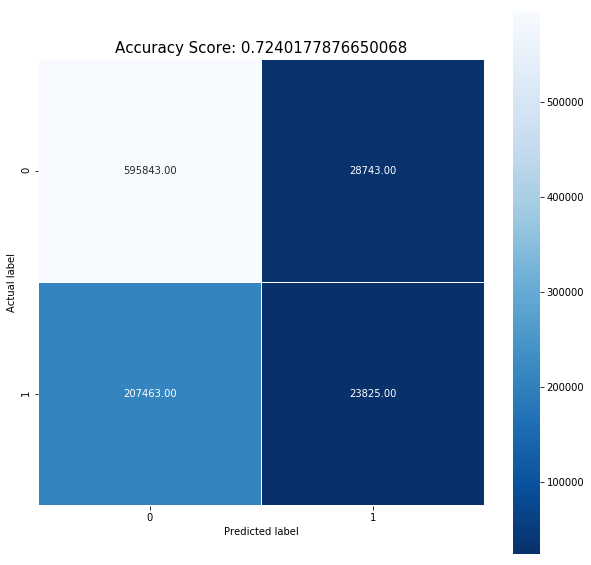

In [11]:
#logistic regression model for arrest rate, using all other data
x_data = encoded_df[['IUCR_encoded','Location Description_encoded','Date_Time','PRIMARY DESCRIPTION_encoded','SECONDARY DESCRIPTION_encoded']]
y_data = encoded_df['Arrest_encoded']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, logisticRegr.coef_[0][idx]))

score = logisticRegr.score(x_test, y_test)
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The coefficient for Location Description_encoded is -1.3174420551261296e-09
The coefficient for Date_Time is -8.914054370515758e-06


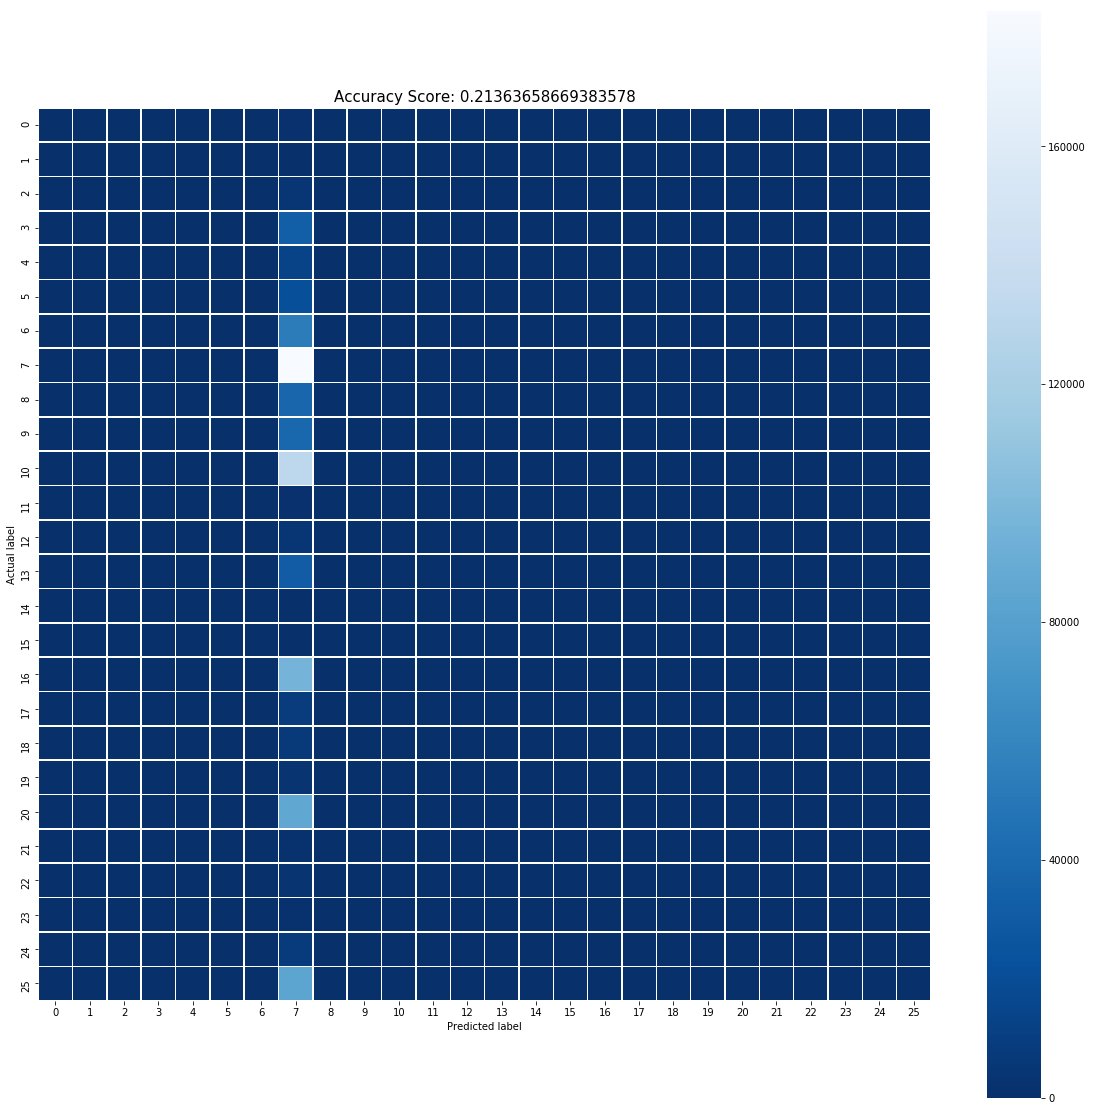

In [12]:
#logistic regression model for FBI Code, using Location and Time
x_data = encoded_df[['Location Description_encoded','Date_Time']]
y_data = encoded_df['FBI Code_encoded']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, logisticRegr.coef_[0][idx]))

score = logisticRegr.score(x_test, y_test)
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(cm, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Logistic Regression is better for categorical data modelling, but since the crimy types have too many categries it is still a very inaccurate model. 

In [13]:
#categorizing location into 4 categories:  1. Residential Area, 2.Public Open Space, 3. Non-Resid Buildings 4. Transporatation, 0.OTHER
loca  = encoded_df['Location Description']
encoded_df.loc[:, 'Loca Num'] = np.where( loca.str.contains('RESIDEN')
                                    |loca.str.contains('APARTMENT'), 1,
                                    np.where(loca.str.contains('STREET')
                                             |loca.str.contains('SIDEWALK')
                                             |loca.str.contains('STATION')
                                             |loca.str.contains('LOT')
                                             |loca.str.contains('ALLEY')
                                             |loca.str.contains('PLATFORM')
                                             |loca.str.contains('HIGHWAY')
                                             |loca.str.contains('BRIDGE')
                                             |loca.str.contains('LAKEFRONT')
                                             |loca.str.contains('FOREST')
                                             |loca.str.contains('LAKE')
                                             |loca.str.contains('RIVER')
                                             |loca.str.contains('PARK'), 2,
                                             np.where(loca.str.contains('BUILDING')
                                                      |loca.str.contains('STORE')
                                                      |loca.str.contains('RESTAURANT')
                                                      |loca.str.contains('SCHOOL')
                                                      |loca.str.contains('OFFICE')
                                                      |loca.str.contains('HOTEL')
                                                      |loca.str.contains('BANK')
                                                      |loca.str.contains('CONSTRUCTION SITE')
                                                      |loca.str.contains('CLUB')
                                                      |loca.str.contains('BARBERSHOP')
                                                      |loca.str.contains('COLLEGE')
                                                      |loca.str.contains('LIBRARY')
                                                      |loca.str.contains('ATM')
                                                      |loca.str.contains('CENTER')
                                                      |loca.str.contains('THEATER')
                                                      |loca.str.contains('CHURCH')
                                                      |loca.str.contains('STADIUM')
                                                      |loca.str.contains('FACILITY')
                                                      |loca.str.contains('SHOP')
                                                      |loca.str.contains('HOSPITAL')
                                                      |loca.str.contains('CREDIT UNION')
                                                      |loca.str.contains('MOTEL')
                                                      |loca.str.contains('AIRPORT')
                                                      |loca.str.contains('FACTORY')
                                                      |loca.str.contains('ROOM')
                                                      |loca.str.contains('BAR'), 3,
                                                      np.where( loca.str.contains('TRANSPORTATION')
                                                                |loca.str.contains('TRUCK')
                                                                |loca.str.contains('BUS')
                                                                |loca.str.contains('TAXICAB')
                                                                |loca.str.contains('VEHICLE')
                                                                |loca.str.contains('TRAIN'), 4,
                                                                0))))

### Linear and Logistic Regression w/ Loca Num

In [14]:
#linear regression model for IUCR, using Location and Time
y_data = encoded_df['IUCR_encoded']
x_data = encoded_df[['Loca Num','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual IUCR code".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Loca Num is -1.147676256093116
The coefficient for Date_Time is -0.002915866656466458
The intercept for our model is 2268.877635716596
0.1332773397040632% of the variability in Y can be explained using X
On average we are 85.0839962914685 away from the actual IUCR code


In [15]:
#linear regression model for FBI Code, using Location and Time
y_data = encoded_df['FBI Code_encoded']
x_data = encoded_df[['Loca Num','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual FBI code".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Loca Num is -0.3202458076989145
The coefficient for Date_Time is -0.00023004944751796235
The intercept for our model is 181.60700502467762
0.3069015064164571% of the variability in Y can be explained using X
On average we are 6.553598454521587 away from the actual FBI code


In [16]:
#linear regression model for Primary Description, using Location and Time
y_data = encoded_df['PRIMARY DESCRIPTION_encoded']
x_data = encoded_df[['Loca Num','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Primary Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for Loca Num is 2.503892405830029
The coefficient for Date_Time is 0.0001166400755196094
The intercept for our model is -75.83484138366384
3.5881486794175466% of the variability in Y can be explained using X
On average we are 11.040006429771921 away from the actual encoded Primary Description


In [17]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Loca Num']
x_data = encoded_df[['PRIMARY DESCRIPTION_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for PRIMARY DESCRIPTION_encoded is 0.014376668142241334
The coefficient for Date_Time is -2.8754615678821715e-06
The intercept for our model is 3.67208725628615
3.6330394675772593% of the variability in Y can be explained using X
On average we are 0.8374809560881662 away from the actual encoded Location Description


In [18]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Loca Num']
x_data = encoded_df[['FBI Code_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for FBI Code_encoded is -0.0054252666080470136
The coefficient for Date_Time is -2.890638825421225e-06
The intercept for our model is 3.953637693552732
0.1644637765823798% of the variability in Y can be explained using X
On average we are 0.8526027713284265 away from the actual encoded Location Description


In [19]:
#linear regression model for Location, using Crime and Time
y_data = encoded_df['Loca Num']
x_data = encoded_df[['IUCR_encoded','Date_Time']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

score = regression_model.score(x_test, y_test) * 100
print("{}% of the variability in Y can be explained using X".format(score))

y_predict = regression_model.predict(x_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_model_mse = math.sqrt(regression_model_mse)
print("On average we are {} away from the actual encoded Location Description".format(regression_model_mse))

#print("Example: ")
#regression_model.predict([[113,732698]])

The coefficient for IUCR_encoded is -0.00011357376312710126
The coefficient for Date_Time is -1.5150314563391408e-06
The intercept for our model is 2.89207141529581
0.01594003362437313% of the variability in Y can be explained using X
On average we are 0.8520814785330859 away from the actual encoded Location Description


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The coefficient for IUCR_encoded is 0.006048400528802508
The coefficient for Loca Num is 2.788607914923583e-05
The coefficient for Date_Time is -3.56750313089851e-06
The coefficient for PRIMARY DESCRIPTION_encoded is 5.753383059388079e-05
The coefficient for SECONDARY DESCRIPTION_encoded is 0.0036737638343563328


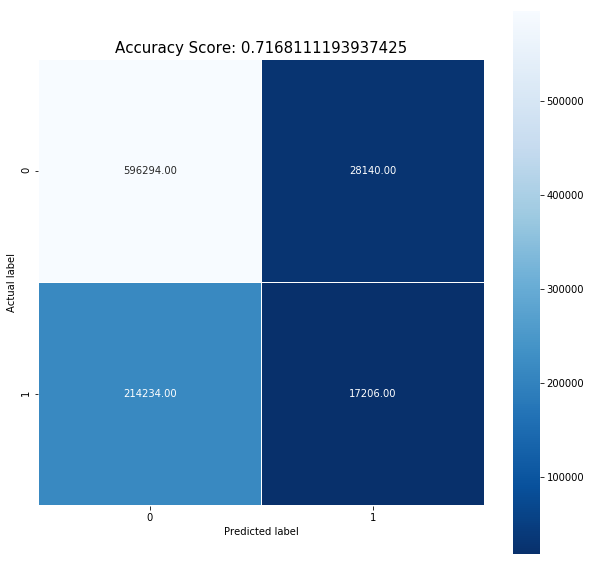

In [20]:
#logistic regression model for arrest rate, using all other data
x_data = encoded_df[['IUCR_encoded','Loca Num','Date_Time','PRIMARY DESCRIPTION_encoded','SECONDARY DESCRIPTION_encoded']]
y_data = encoded_df['Arrest_encoded']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, logisticRegr.coef_[0][idx]))

score = logisticRegr.score(x_test, y_test)
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The coefficient for Loca Num is -2.3866189438817878e-11
The coefficient for Date_Time is -8.913335872635901e-06


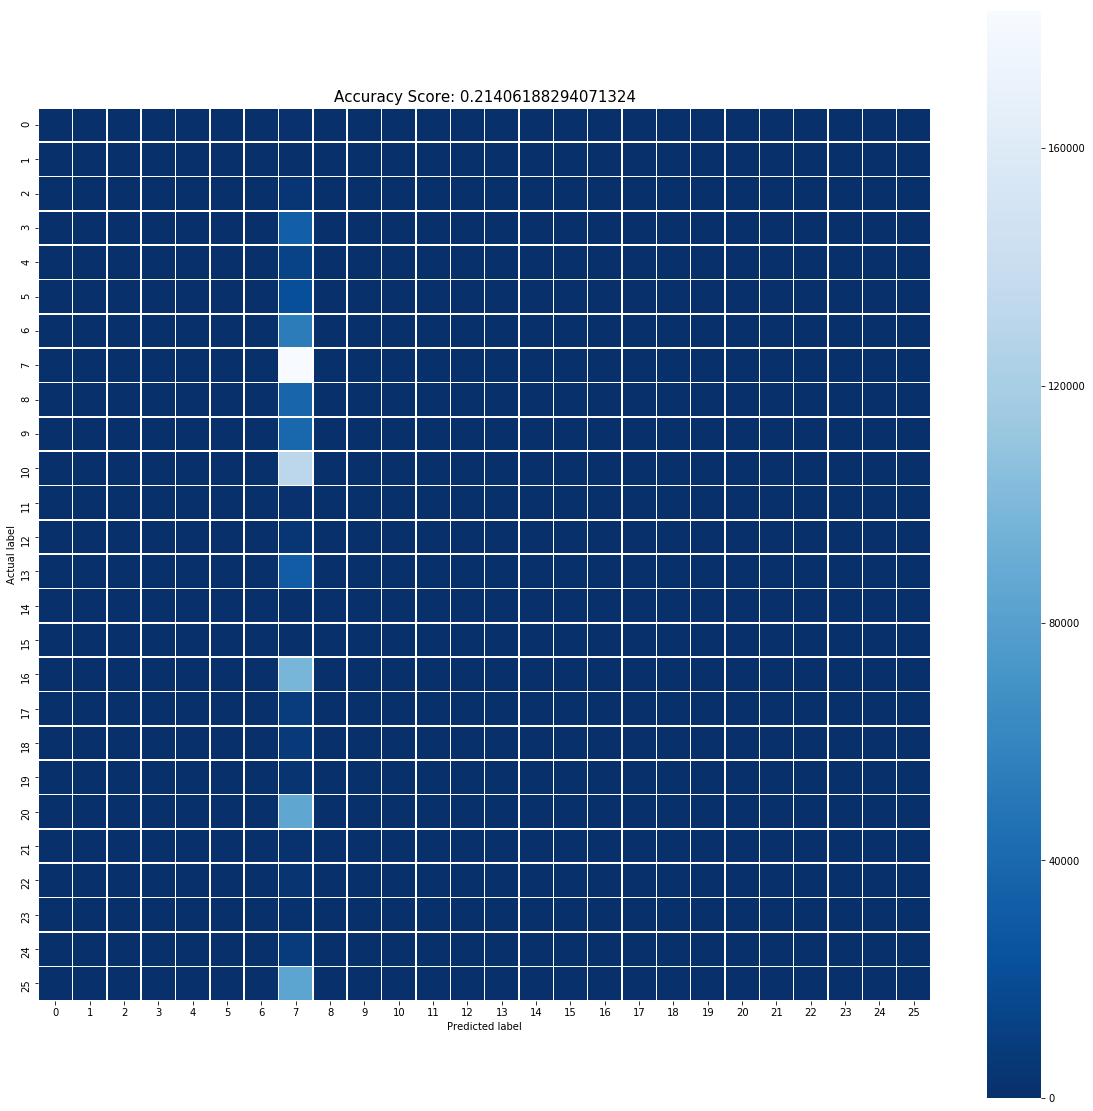

In [21]:
#logistic regression model for FBI Code, using Location and Time
x_data = encoded_df[['Loca Num','Date_Time']]
y_data = encoded_df['FBI Code_encoded']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, logisticRegr.coef_[0][idx]))

score = logisticRegr.score(x_test, y_test)
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(cm, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The coefficient for IUCR_encoded is -7.122260300127615e-10
The coefficient for Arrest_encoded is -1.9543041630657623e-12
The coefficient for Date_Time is -4.112895115399192e-06
The coefficient for PRIMARY DESCRIPTION_encoded is -7.30368495230256e-11
The coefficient for SECONDARY DESCRIPTION_encoded is -1.1558671510927873e-09


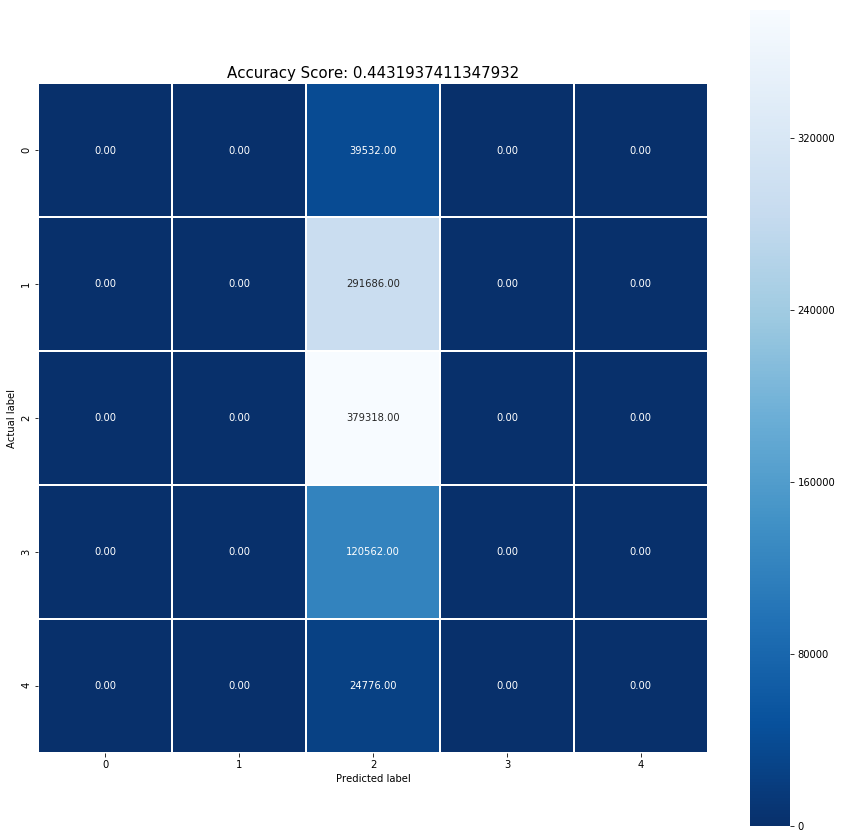

In [23]:
#logistic regression model for Location, using other data
x_data = encoded_df[['IUCR_encoded','Arrest_encoded','Date_Time','PRIMARY DESCRIPTION_encoded','SECONDARY DESCRIPTION_encoded']]
y_data = encoded_df['Loca Num']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, logisticRegr.coef_[0][idx]))

score = logisticRegr.score(x_test, y_test)
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Data Preprocessing for RF, GB, and NN

In [21]:
# load dataset 

df = pd.read_csv("cleanedData.csv")
df.head(10)

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


In [22]:
# run Random Forest Regression 
df.dtypes
hours = pd.to_datetime(df['Time']).dt.hour
hours.head(10)


0    10
1    18
2     9
3    19
4    14
5    11
6    13
7     1
8     9
9     2
Name: Time, dtype: int64

In [23]:
loca  = df['Location Description']
loca.unique().tolist()

['RESIDENCE',
 'STREET',
 'SIDEWALK',
 'FACTORY/MANUFACTURING BUILDING',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'GAS STATION',
 'RESIDENCE-GARAGE',
 'CHA PARKING LOT/GROUNDS',
 'RESTAURANT',
 'NURSING HOME/RETIREMENT HOME',
 'OTHER',
 'VACANT LOT/LAND',
 'GROCERY FOOD STORE',
 'CONSTRUCTION SITE',
 'SCHOOL, PRIVATE, BUILDING',
 'CLEANING STORE',
 'WAREHOUSE',
 'APARTMENT',
 'ALLEY',
 'COMMERCIAL / BUSINESS OFFICE',
 'HOTEL/MOTEL',
 'DRIVEWAY - RESIDENTIAL',
 'BAR OR TAVERN',
 'RESIDENCE PORCH/HALLWAY',
 'CTA TRAIN',
 'VEHICLE NON-COMMERCIAL',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'SMALL RETAIL STORE',
 'ATHLETIC CLUB',
 'TAVERN/LIQUOR STORE',
 'CONVENIENCE STORE',
 'GOVERNMENT BUILDING/PROPERTY',
 'HOSPITAL BUILDING/GROUNDS',
 'DEPARTMENT STORE',
 'OTHER COMMERCIAL TRANSPORTATION',
 'CHA HALLWAY/STAIRWELL/ELEVATOR',
 'CHA APARTMENT',
 'DRUG STORE',
 'BARBERSHOP',
 'SCHOOL, PUBLIC, BUILDING',
 'CTA BUS',
 'TAXICAB',
 'VEHICLE-COMMERCIAL',
 'PARK PROPERTY',
 'POLICE FACILITY/VEH PARKING LOT',


In [24]:
newDf = df.copy()

# its hard to build a model that predicts the type of a crime location
# in 157 categories, therefore, we separate these location types into fewer categories 
# 1. Residential Area, 2.Public Open Space, 3. Non-Resid Buildings 4. Transporatation, 0.OTHER
newDf.loc[:, 'Loca Num'] = np.where( loca.str.contains('RESIDEN')
                                    |loca.str.contains('APARTMENT'), 1,
                                    np.where(loca.str.contains('STREET')
                                             |loca.str.contains('SIDEWALK')
                                             |loca.str.contains('STATION')
                                             |loca.str.contains('LOT')
                                             |loca.str.contains('ALLEY')
                                             |loca.str.contains('PLATFORM')
                                             |loca.str.contains('HIGHWAY')
                                             |loca.str.contains('BRIDGE')
                                             |loca.str.contains('LAKEFRONT')
                                             |loca.str.contains('FOREST')
                                             |loca.str.contains('LAKE')
                                             |loca.str.contains('RIVER')
                                             |loca.str.contains('PARK'), 2,
                                             np.where(loca.str.contains('BUILDING')
                                                      |loca.str.contains('STORE')
                                                      |loca.str.contains('RESTAURANT')
                                                      |loca.str.contains('SCHOOL')
                                                      |loca.str.contains('OFFICE')
                                                      |loca.str.contains('HOTEL')
                                                      |loca.str.contains('BANK')
                                                      |loca.str.contains('CONSTRUCTION SITE')
                                                      |loca.str.contains('CLUB')
                                                      |loca.str.contains('BARBERSHOP')
                                                      |loca.str.contains('COLLEGE')
                                                      |loca.str.contains('LIBRARY')
                                                      |loca.str.contains('ATM')
                                                      |loca.str.contains('CENTER')
                                                      |loca.str.contains('THEATER')
                                                      |loca.str.contains('CHURCH')
                                                      |loca.str.contains('STADIUM')
                                                      |loca.str.contains('FACILITY')
                                                      |loca.str.contains('SHOP')
                                                      |loca.str.contains('HOSPITAL')
                                                      |loca.str.contains('CREDIT UNION')
                                                      |loca.str.contains('MOTEL')
                                                      |loca.str.contains('AIRPORT')
                                                      |loca.str.contains('FACTORY')
                                                      |loca.str.contains('ROOM')
                                                      |loca.str.contains('BAR'), 3,
                                                      np.where( loca.str.contains('TRANSPORTATION')
                                                                |loca.str.contains('TRUCK')
                                                                |loca.str.contains('BUS')
                                                                |loca.str.contains('TAXICAB')
                                                                |loca.str.contains('VEHICLE')
                                                                |loca.str.contains('TRAIN'), 4,
                                                                0))))
                                                               

In [25]:
# Label Encoding categorical data 
newDf.drop(['ID', 'Time', 'Location Description'], axis = 1, inplace = True)
newDf['Hours'] = hours

# all categorical data
categories = ['IUCR','Arrest',
           'FBI Code', 'Domestic', 'Month', 'DayofWeek',
           'PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'INDEX CODE', 'Hours']
encoders = {}

for i in categories:
    # Create a label (category) encoder object
    encoders[i] = preprocessing.LabelEncoder()

    # Fit the encoder to the pandas column
    encoders[i].fit(newDf[i])
    
    # View the labels (if you want)
    #list(le.classes_)
    
    # Apply the fitted encoder to the pandas column
    trans = encoders[i].transform(newDf[i]) 
    
    # Append to DataFrame
    newName = i + '_encoded'
    newDf.loc[:, newName] = pd.Series(trans, index = newDf.index)

newDf.describe()

,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
count,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06
mean,1.181222e+03,1.130010e+01,2.010991e+03,1.564463e+01,1.765142e+00,1.315196e+01,1.257202e+02,2.700856e-01,1.211051e+01,1.383998e-01,5.576326e+00,2.982576e+00,1.423277e+01,2.029977e+02,1.553849e+00,1.315196e+01
std,7.002026e+02,6.926531e+00,2.841988e+00,8.829594e+00,8.529346e-01,6.717154e+00,8.506388e+01,4.440039e-01,6.568510e+00,3.453191e-01,3.460171e+00,2.019707e+00,1.124264e+01,1.090440e+02,5.534576e-01,6.717154e+00
min,1.110000e+02,1.000000e+00,2.007000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.210000e+02,6.000000e+00,2.008000e+03,8.000000e+00,1.000000e+00,9.000000e+00,7.600000e+01,0.000000e+00,7.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.300000e+02,1.000000e+00,9.000000e+00
50%,1.032000e+03,1.000000e+01,2.011000e+03,1.600000e+01,2.000000e+00,1.400000e+01,9.400000e+01,0.000000e+00,1.000000e+01,0.000000e+00,6.000000e+00,3.000000e+00,1.600000e+01,2.420000e+02,2.000000e+00,1.400000e+01
75%,1.723000e+03,1.700000e+01,2.013000e+03,2.300000e+01,2.000000e+00,1.900000e+01,1.550000e+02,1.000000e+00,1.600000e+01,0.000000e+00,9.000000e+00,5.000000e+00,2.700000e+01,3.010000e+02,2.000000e+00,1.900000e+01
max,2.535000e+03,3.100000e+01,2.016000e+03,3.100000e+01,4.000000e+00,2.300000e+01,3.850000e+02,1.000000e+00,2.500000e+01,1.000000e+00,1.100000e+01,6.000000e+00,3.100000e+01,3.630000e+02,2.000000e+00,2.300000e+01


,Arrest,Domestic,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
Arrest,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836
Domestic,-0.067204,1.000000,-0.043635,-0.041463,0.039201,-0.000403,-0.224316,-0.032560,-0.092023,-0.067204,0.014134,1.000000,-0.007389,-0.008226,-0.260474,-0.117564,0.126900,-0.032560
Beat,-0.022398,-0.043635,1.000000,0.955455,-0.032835,-0.001028,0.020929,-0.012246,0.004587,-0.022398,-0.008005,-0.043635,0.000413,-0.007906,0.039693,-0.001622,0.021951,-0.012246
District,-0.019107,-0.041463,0.955455,1.000000,-0.003835,-0.000951,0.019623,-0.012674,0.005900,-0.019107,-0.006370,-0.041463,0.000737,-0.008135,0.035361,-0.001012,0.018611,-0.012674
Year,-0.032576,0.039201,-0.032835,-0.003835,1.000000,0.001093,-0.001456,0.006844,-0.032584,-0.032576,-0.033159,0.039201,-0.004227,-0.003604,0.009906,-0.046992,0.012712,0.006844
Day,-0.000739,-0.000403,-0.001028,-0.000951,0.001093,1.000000,0.008839,0.016261,-0.009353,-0.000739,-0.008404,-0.000403,0.003395,-0.000335,-0.004819,0.002312,0.005476,0.016261
Loca Num,0.139463,-0.224316,0.020929,0.019623,-0.001456,0.008839,1.000000,0.040782,-0.011573,0.139463,-0.041395,-0.224316,0.008215,0.004239,0.189780,0.038849,0.005214,0.040782
Hours,0.088836,-0.032560,-0.012246,-0.012674,0.006844,0.016261,0.040782,1.000000,0.060034,0.088836,0.060187,-0.032560,0.002139,0.008238,0.030308,0.049960,-0.031730,1.000000
IUCR_encoded,0.360453,-0.092023,0.004587,0.005900,-0.032584,-0.009353,-0.011573,0.060034,1.000000,0.360453,0.866689,-0.092023,-0.010969,0.009607,0.203480,0.305674,-0.616860,0.060034
Arrest_encoded,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836


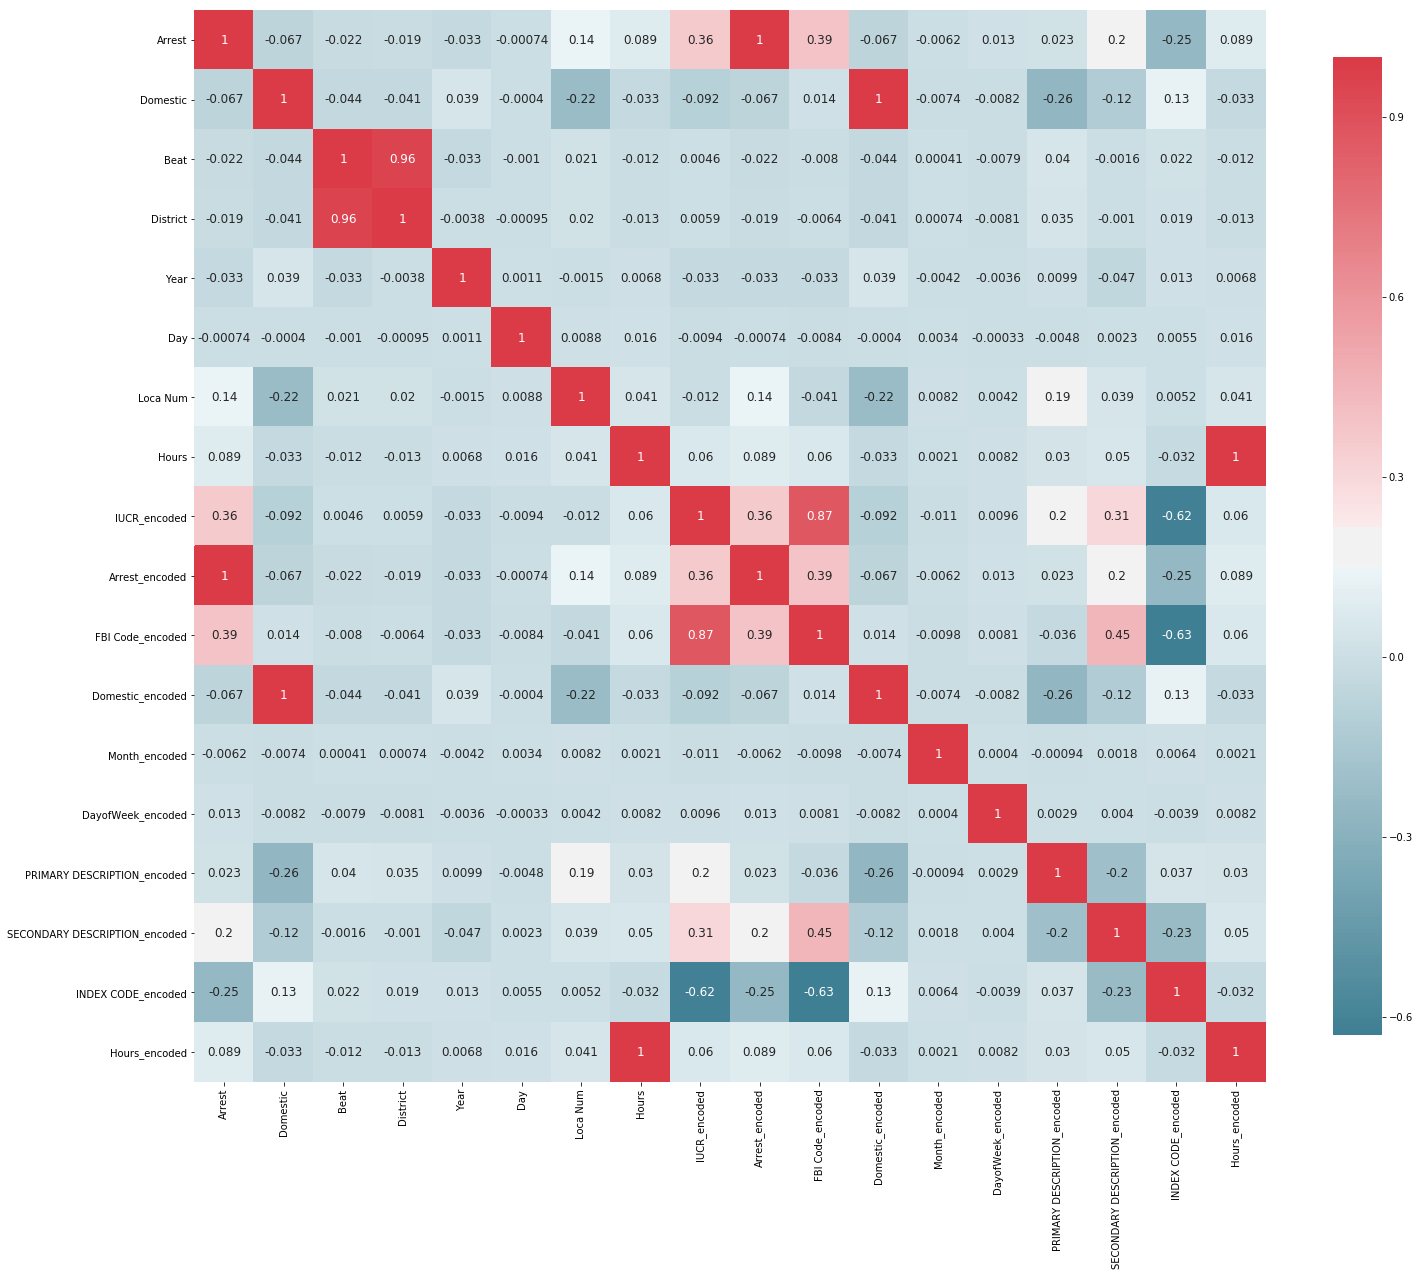

In [26]:
def plot_correlation_map(df):
    """
    This function plots the correlation map of a given dataframe
    """
    corr = df.corr()
    _ , ax = plt.subplots( figsize =(24, 20 ) )
    cmap = sns.diverging_palette(220, 10, as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )


plot_correlation_map(newDf)
newDf.corr()

In [27]:
from sklearn.cross_validation import train_test_split

# MODEL FEATURES: TIME, LOCATION, determine TYPE 
location = newDf['Loca Num']
train1 = newDf[['Month_encoded', 'DayofWeek_encoded',
           'PRIMARY DESCRIPTION_encoded', 'Hours', 'District']]


# split our data into train and test
x_train , x_test , y_train , y_test = train_test_split(train1 , location , test_size = 0.30,random_state =2)

In [43]:
# build random forest model

# count time building the model 
time_start = time.clock()

trees = 35
depth = 15

rf = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf.fit(x_train, y_train)

pred = rf.predict(x_test)
comparison = pd.crosstab(y_test, pred)

time1 = (time.clock() - time_start)


print("Time to build a Random Forest Model is:", time1)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred))

Time to build a Random Forest Model is: 321.88747
Test Accuracy:  0.5850012998406113


In [44]:
# count time building the model 
time_start = time.clock()

trees = 35
depth = 5

rf2 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf2.fit(x_train, y_train)

pred2 = rf2.predict(x_test)
comparison2 = pd.crosstab(y_test, pred2)

time2 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred2))

time to build a Random Forest Model is: 158.120453
Test Accuracy:  0.5487527858943438


In [45]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 15

rf3 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf3.fit(x_train, y_train)

pred3 = rf3.predict(x_test)
comparison3 = pd.crosstab(y_test, pred3)

time3 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred3))

time to build a Random Forest Model is: 144.13934900000004
Test Accuracy:  0.5844735742890553


In [46]:
# count time building the model 
time_start = time.clock()

trees = 50
depth = 15

rf4 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf4.fit(x_train, y_train)

pred4 = rf4.predict(x_test)
comparison4 = pd.crosstab(y_test, pred4)

time4 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred4))

time to build a Random Forest Model is: 453.953808
Test Accuracy:  0.5849944841969565


In [47]:
# count time building the model 
time_start = time.clock()

trees = 100
depth = 15

rf5 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf5.fit(x_train, y_train)

pred5 = rf5.predict(x_test)
comparison5 = pd.crosstab(y_test, pred5)

time5 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time5)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred5))

time to build a Random Forest Model is: 901.5171269999998
Test Accuracy:  0.5851979798432208


In [49]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 25

rf6 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf6.fit(x_train, y_train)

pred6 = rf6.predict(x_test)
comparison6 = pd.crosstab(y_test, pred6)

time6 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time6)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred6))

time to build a Random Forest Model is: 149.25837899999988
Test Accuracy:  0.5466486993317748


In [50]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 35

rf7 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf7.fit(x_train, y_train)

pred7 = rf7.predict(x_test)
comparison7 = pd.crosstab(y_test, pred7)

time7 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time7)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred7))

time to build a Random Forest Model is: 159.5784209999997
Test Accuracy:  0.5428592014597161


In [56]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 5

rf8 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf8.fit(x_train, y_train)

pred8 = rf8.predict(x_test)
comparison8 = pd.crosstab(y_test, pred8)

time8 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time8)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred8))

time to build a Random Forest Model is: 64.82272700000249
Test Accuracy:  0.5473146850831849


<Figure size 432x288 with 0 Axes>

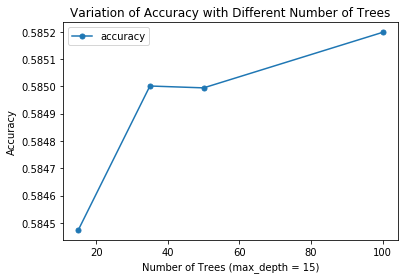

In [72]:
# diff number of trees 
# depth = 15

d = pd.DataFrame(
    data = {'ntree': [15, 35, 50, 100], 
            'accuracy': [metrics.accuracy_score(y_test, pred3),
                         metrics.accuracy_score(y_test, pred),
                         metrics.accuracy_score(y_test, pred4),
                         metrics.accuracy_score(y_test, pred5)]})

plt.figure()
d.plot(x = 'ntree', y = 'accuracy', marker='.', markersize=10, 
       title='Variation of Accuracy with Different Number of Trees')

plt.xlabel("Number of Trees (max_depth = 15)")
plt.ylabel("Accuracy")
plt.savefig('num_tree.png')
plt.show()

<Figure size 432x288 with 0 Axes>

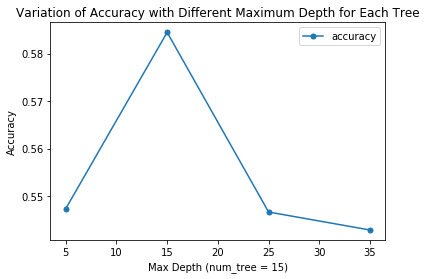

In [70]:
# diff number of max_depth
# trees = 15

d2 = pd.DataFrame(
    data = {'max_depth': [5, 15, 25, 35], 
            'accuracy': [metrics.accuracy_score(y_test, pred8),
                         metrics.accuracy_score(y_test, pred3),
                         metrics.accuracy_score(y_test, pred6),
                         metrics.accuracy_score(y_test, pred7)]})
            #'time': [time8, time3, time6, time7]})

plt.figure()
d2.plot(x = 'max_depth', y = 'accuracy', marker='.', markersize=10, 
       title='Variation of Accuracy with Different Maximum Depth for Each Tree')

plt.xlabel("Max Depth (num_tree = 15)")
plt.ylabel("Accuracy")
plt.savefig('max_depth.png')
plt.show()

### Final model for Random Forest (using rf with trees=35 and depth=15 )

In [73]:
# displays the precision, recall, F1, and support scores for the model

# Precision is the ability of a classiifer not to label an instance positive that is actually negative. 
# for all instances classified positive, what percent was correct

# Recall is the ability of a classifier to find all positive instances.
# for all instances that were actually positive, what percent was classified correctly

# The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0

# Support is the number of actual occurrences of the class in the specified dataset. 

report =  metrics.classification_report(y_test, pred)
print(report)

             precision    recall  f1-score   support

          0       0.27      0.01      0.01     48043
          1       0.58      0.64      0.61    349275
          2       0.61      0.74      0.67    455281
          3       0.46      0.26      0.33    144915
          4       0.33      0.00      0.01     29535

avg / total       0.55      0.59      0.55   1027049



In [ ]:
# confusion matrix 
# https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[   345  18033  22349   7290     26]
 [   140 223345 112812  12891     87]
 [   335  94003 338938  21894    111]
 [   417  42618  63771  38064     45]
 [    62   6756  19390   3194    133]]


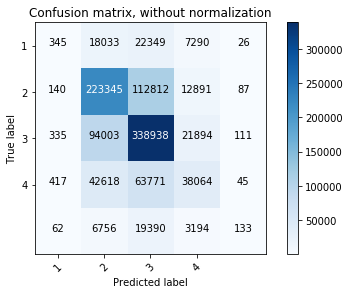

In [74]:
    
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('rf_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.01 0.38 0.47 0.15 0.  ]
 [0.   0.64 0.32 0.04 0.  ]
 [0.   0.21 0.74 0.05 0.  ]
 [0.   0.29 0.44 0.26 0.  ]
 [0.   0.23 0.66 0.11 0.01]]


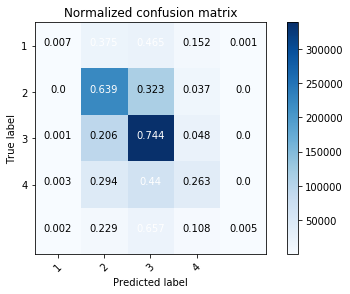

In [75]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('rf_cm_w_normal.png')
plt.show()

### Feature Importanace (RF)

In [77]:
featureImp = pd.DataFrame(
    {"Features": train1.columns.tolist(),
     "Feature Importance": rf.feature_importances_.tolist()  
    })
featureImp["Features"] = featureImp["Features"].str.replace('_encoded', '', regex=True)
featureImp.sort_values(by = "Feature Importance" , ascending=False)

,Features,Feature Importance
2,PRIMARY DESCRIPTION,0.697917
4,District,0.118878
3,Hours,0.115968
0,Month,0.036127
1,DayofWeek,0.031111


<Figure size 432x288 with 0 Axes>

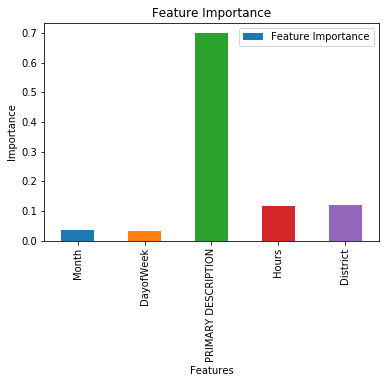

In [78]:
# plot feature importance 

plt.figure()
featureImp.plot.bar(x = 'Features', y = 'Feature Importance', 
       title='Feature Importance')

plt.xlabel("Features")
plt.ylabel("Importance")
plt.savefig('rd_feature_imp.png')
plt.show()

# Gradient Boosting 

In [39]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr = ensemble.GradientBoostingRegressor(n_estimators = 15, max_depth = 5,
                                         loss = 'ls')

gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_test)
gbr_comparison = pd.crosstab(y_test, gbr_pred)

grd_time = (time.clock() - time_start)

print("time to build a Gradient Boosting Model is:", grd_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred.round()))

time to build a Gradient Boosting Model is: 88.8652230000007
Test Accuracy:  0.5173005377542844


In [47]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr2 = ensemble.GradientBoostingRegressor(n_estimators = 35, max_depth = 5,
                                         loss = 'ls')

gbr2.fit(x_train, y_train)

gbr_pred2 = gbr2.predict(x_test)
gbr_comparison2 = pd.crosstab(y_test, gbr_pred2)

grd_time2 = (time.clock() - time_start)
print("time to build a Gradient Boosting Model is:", grd_time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred2.round()))

time to build a Gradient Boosting Model is: 207.81080199999997
Test Accuracy:  0.5252105790473482


In [46]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr3 = ensemble.GradientBoostingRegressor(n_estimators = 50, max_depth = 5,
                                         loss = 'ls')

gbr3.fit(x_train, y_train)

gbr_pred3 = gbr3.predict(x_test)
gbr_comparison3 = pd.crosstab(y_test, gbr_pred3)

grd_time3 = (time.clock() - time_start)
print("time to build a Gradient Boosting Model is:", grd_time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred3.round()))

time to build a Gradient Boosting Model is: 287.8287249999994
Test Accuracy:  0.5297965335636372


In [54]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr4 = ensemble.GradientBoostingRegressor(n_estimators = 15, max_depth = 10,
                                         loss = 'ls')

gbr4.fit(x_train, y_train)
gbr_pred4 = gbr4.predict(x_test)
gbr_comparison4 = pd.crosstab(y_test, gbr_pred)

grd_time4 = (time.clock() - time_start)

print("time to build a Gradient Boosting Model is:", grd_time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred4.round()))

time to build a Gradient Boosting Model is: 1119.4728370000012
Test Accuracy:  0.5258931170762057


### Final model for Gradient Boosting( N_tree = 50, max_depth=5)

In [48]:
report =  metrics.classification_report(y_test, gbr_pred3.round())
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     48043
          1       0.72      0.32      0.44    349275
          2       0.50      0.95      0.65    455281
          3       0.64      0.02      0.03    144915
          4       0.00      0.00      0.00     29535

avg / total       0.56      0.53      0.44   1027049



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[     0   6341  41391    311      0]
 [     0 110574 238607     94      0]
 [     0  23309 431320    652      0]
 [     0  10662 132020   2233      0]
 [     0   1717  27598    220      0]]


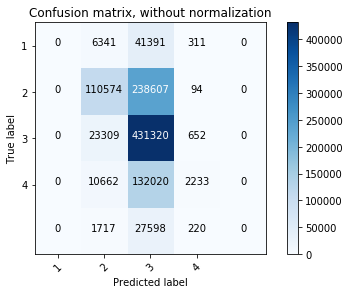

In [49]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, gbr_pred3.round())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('gbr_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.   0.13 0.86 0.01 0.  ]
 [0.   0.32 0.68 0.   0.  ]
 [0.   0.05 0.95 0.   0.  ]
 [0.   0.07 0.91 0.01 0.  ]
 [0.   0.06 0.93 0.01 0.  ]]


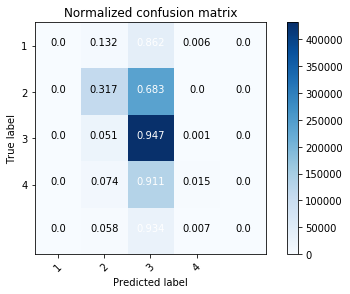

In [50]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('gbr_cm_w_normal.png')
plt.show()

# Deep Neural Network

In [55]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487


y_train2 = to_categorical(y_train, num_classes=5)
y_test2 = to_categorical(y_test, num_classes=5)

# count time building the model 
time_start = time.clock()

nn = Sequential()
nn.add(Dense(128, input_dim=5, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(5, activation='softmax'))
nn.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn.fit(x_train, y_train2, batch_size=128, epochs=5)

nn_pred = nn.predict_classes(x_test)

nn_time = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred))

Epoch 1/5
2396447/2396447 [==============================] - 182s 76us/step - loss: 1.1486 - acc: 0.5160
Epoch 2/5
2396447/2396447 [==============================] - 168s 70us/step - loss: 1.1230 - acc: 0.5247
Epoch 3/5
2396447/2396447 [==============================] - 180s 75us/step - loss: 1.0995 - acc: 0.5374
Epoch 4/5
2396447/2396447 [==============================] - 175s 73us/step - loss: 1.0787 - acc: 0.5531
Epoch 5/5
2396447/2396447 [==============================] - 188s 78us/step - loss: 1.0696 - acc: 0.5575
time to build a Neural Network Model is: 2663.3100399999967
Test Accuracy:  0.5580376398789152


In [19]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487

# count time building the model 
time_start = time.clock()

nn2 = Sequential()
nn2.add(Dense(128, input_dim=5, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(5, activation='softmax'))
nn2.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn2.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred2 = nn2.predict_classes(x_test)

nn_time2 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred2))

Epoch 1/5
2396447/2396447 [==============================] - 121s 51us/step - loss: 1.1513 - acc: 0.5170
Epoch 2/5
2396447/2396447 [==============================] - 118s 49us/step - loss: 1.1117 - acc: 0.5297
Epoch 3/5
2396447/2396447 [==============================] - 111s 46us/step - loss: 1.0874 - acc: 0.5462
Epoch 4/5
2396447/2396447 [==============================] - 110s 46us/step - loss: 1.0749 - acc: 0.5552
Epoch 5/5
2396447/2396447 [==============================] - 115s 48us/step - loss: 1.0679 - acc: 0.5588
time to build a Neural Network Model is: 2089.3632699999994
Test Accuracy:  0.5648114160083891


In [21]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487

# count time building the model 
time_start = time.clock()

nn3 = Sequential()
nn3.add(Dense(128, input_dim=5, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(5, activation='softmax'))
nn3.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn3.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred3 = nn3.predict_classes(x_test)

nn_time3 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred3))

Epoch 1/5
2396447/2396447 [==============================] - 176s 74us/step - loss: 1.2323 - acc: 0.4666
Epoch 2/5
2396447/2396447 [==============================] - 176s 74us/step - loss: 1.2118 - acc: 0.5048
Epoch 3/5
2396447/2396447 [==============================] - 178s 74us/step - loss: 1.2038 - acc: 0.5063
Epoch 4/5
2396447/2396447 [==============================] - 167s 70us/step - loss: 1.1922 - acc: 0.5072
Epoch 5/5
2396447/2396447 [==============================] - 164s 69us/step - loss: 1.1812 - acc: 0.5069
time to build a Neural Network Model is: 2928.629446000001
Test Accuracy:  0.5072367530663094


In [33]:
# optimal number for nodes 
# count time building the model 
time_start = time.clock()

nn4 = Sequential()
nn4.add(Dense(64, input_dim=5, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(5, activation='softmax'))
nn4.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn4.fit(x_train, y_train2, batch_size=64, epochs=5)
nn_pred4 = nn4.predict_classes(x_test)

nn_time4 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred4))

Epoch 1/5
2396447/2396447 [==============================] - 173s 72us/step - loss: 1.1421 - acc: 0.5196
Epoch 2/5
2396447/2396447 [==============================] - 173s 72us/step - loss: 1.0960 - acc: 0.5396
Epoch 3/5
2396447/2396447 [==============================] - 162s 68us/step - loss: 1.0773 - acc: 0.5540
Epoch 4/5
2396447/2396447 [==============================] - 150s 63us/step - loss: 1.0685 - acc: 0.55840s - loss: 1.0686 - 
Epoch 5/5
2396447/2396447 [==============================] - 151s 63us/step - loss: 1.0638 - acc: 0.5600
time to build a Neural Network Model is: 2728.9202149999983
Test Accuracy:  0.5607775286281375


In [34]:
# optimal number for nodes 
# count time building the model 
time_start = time.clock()

nn5 = Sequential()
nn5.add(Dense(256, input_dim=5, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(5, activation='softmax'))
nn5.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn5.fit(x_train, y_train2, batch_size=256, epochs=5)
nn_pred5 = nn5.predict_classes(x_test)

nn_time5 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time5)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred5))

Epoch 1/5
2396447/2396447 [==============================] - 156s 65us/step - loss: 1.1621 - acc: 0.5139
Epoch 2/5
2396447/2396447 [==============================] - 162s 68us/step - loss: 1.1307 - acc: 0.5229
Epoch 3/5
2396447/2396447 [==============================] - 169s 70us/step - loss: 1.1141 - acc: 0.5287
Epoch 4/5
2396447/2396447 [==============================] - 154s 64us/step - loss: 1.0995 - acc: 0.5353
Epoch 5/5
2396447/2396447 [==============================] - 169s 71us/step - loss: 1.0873 - acc: 0.5444
time to build a Neural Network Model is: 2735.802536000003
Test Accuracy:  0.5463604949715155


In [51]:
# most efficient shape 
# increasing 

# count time building the model 
time_start = time.clock()

nn6 = Sequential()
nn6.add(Dense(64, input_dim=5, activation='relu'))
nn6.add(Dense(128, activation='relu'))
nn6.add(Dense(128, activation='relu'))
nn6.add(Dense(256, activation='relu'))
nn6.add(Dense(5, activation='softmax'))
nn6.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn6.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred6 = nn6.predict_classes(x_test)

nn_time6 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time6)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred6))


Epoch 1/5
2396447/2396447 [==============================] - 142s 59us/step - loss: 1.1567 - acc: 0.5151
Epoch 2/5
2396447/2396447 [==============================] - 147s 61us/step - loss: 1.1187 - acc: 0.5271
Epoch 3/5
2396447/2396447 [==============================] - 146s 61us/step - loss: 1.0953 - acc: 0.5382
Epoch 4/5
2396447/2396447 [==============================] - 138s 58us/step - loss: 1.0805 - acc: 0.5494
Epoch 5/5
2396447/2396447 [==============================] - 167s 70us/step - loss: 1.0723 - acc: 0.5551
time to build a Neural Network Model is: 2259.982355
Test Accuracy:  0.5425943650205589


In [52]:
# most efficient shape 
# decreasing 

# count time building the model 
time_start = time.clock()

nn7 = Sequential()
nn7.add(Dense(256, input_dim=5, activation='relu'))
nn7.add(Dense(128, activation='relu'))
nn7.add(Dense(128, activation='relu'))
nn7.add(Dense(64, activation='relu'))
nn7.add(Dense(5, activation='softmax'))
nn7.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn7.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred7 = nn7.predict_classes(x_test)

nn_time7 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time7)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred7))



Epoch 1/5
2396447/2396447 [==============================] - 168s 70us/step - loss: 1.1519 - acc: 0.5167
Epoch 2/5
2396447/2396447 [==============================] - 163s 68us/step - loss: 1.1127 - acc: 0.5280
Epoch 3/5
2396447/2396447 [==============================] - 178s 74us/step - loss: 1.0900 - acc: 0.5444
Epoch 4/5
2396447/2396447 [==============================] - 183s 77us/step - loss: 1.0783 - acc: 0.5530
Epoch 5/5
2396447/2396447 [==============================] - 169s 71us/step - loss: 1.0710 - acc: 0.5576
time to build a Neural Network Model is: 2263.271894999998
Test Accuracy:  0.5544428746827075


In [53]:
# most efficient shape 
# diamond

# count time building the model 
time_start = time.clock()

nn8 = Sequential()
nn8.add(Dense(64, input_dim=5, activation='relu'))
nn8.add(Dense(128, activation='relu'))
nn8.add(Dense(256, activation='relu'))
nn8.add(Dense(128, activation='relu'))
nn8.add(Dense(5, activation='softmax'))
nn8.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn8.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred8 = nn8.predict_classes(x_test)

nn_time8 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time8)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred8))



Epoch 1/5
2396447/2396447 [==============================] - 166s 69us/step - loss: 1.1542 - acc: 0.5160
Epoch 2/5
2396447/2396447 [==============================] - 171s 71us/step - loss: 1.1146 - acc: 0.5288
Epoch 3/5
2396447/2396447 [==============================] - 182s 76us/step - loss: 1.0901 - acc: 0.5442
Epoch 4/5
2396447/2396447 [==============================] - 158s 66us/step - loss: 1.0765 - acc: 0.5547
Epoch 5/5
2396447/2396447 [==============================] - 152s 63us/step - loss: 1.0687 - acc: 0.5589
time to build a Neural Network Model is: 2283.9071760000006
Test Accuracy:  0.5595672650477241


### Final model for DNN (activation function = relu, constant shaped, number of nodes = 128)

In [35]:
report =  metrics.classification_report(y_test, nn_pred2)
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     48043
          1       0.56      0.61      0.59    349275
          2       0.58      0.75      0.65    455281
          3       0.43      0.19      0.26    144915
          4       0.00      0.00      0.00     29535

avg / total       0.51      0.56      0.53   1027049



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[     0  17193  24522   6328      0]
 [     0 211978 128145   9152      0]
 [     0  96947 340796  17538      0]
 [     0  42957  74643  27315      0]
 [     0   6347  20500   2688      0]]


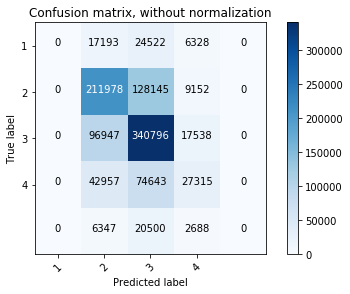

In [36]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, nn_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('nn_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.   0.36 0.51 0.13 0.  ]
 [0.   0.61 0.37 0.03 0.  ]
 [0.   0.21 0.75 0.04 0.  ]
 [0.   0.3  0.52 0.19 0.  ]
 [0.   0.21 0.69 0.09 0.  ]]


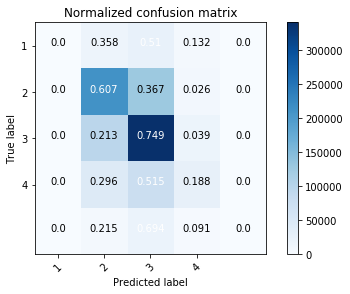

In [37]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nn_cm_w_normal.png')
plt.show()

# K-means

In [3]:
crimeData = pd.read_csv('cleanedData.csv')
crimeData.head(10)

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


In [4]:
def make_clusters(data, num_clusters):
    km = KModes(n_clusters = num_clusters, init = 'Cao', n_init = 1, verbose = 1)
    fit_clusters = km.fit_predict(data)
    cluster_centroidsdf = pd.DataFrame(km.cluster_centroids_)
    cluster_centroidsdf.columns = data.columns
    
    return fit_clusters, cluster_centroidsdf
    

In [5]:
make_clusters(crimeData, 10)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 460436, cost: 36522074.0
Run 1, iteration: 2/100, moves: 26852, cost: 36522074.0


(array([1, 2, 0, ..., 3, 1, 4], dtype=uint16),
      ID  IUCR Location Description Arrest Domestic  Beat District FBI Code  \
 0  3938  0820               STREET  False    False   823      8.0       06   
 1  3986  0486            RESIDENCE  False     True   624      6.0      08B   
 2  3957  1320               STREET  False    False  1112     11.0       14   
 3  3962  0560             SIDEWALK  False    False   424      4.0      08A   
 4  4272  1811               STREET   True    False  1533     11.0       18   
 5  3944  0610            APARTMENT  False    False   733      7.0       05   
 6  3934  0460               STREET  False    False  1113     11.0      08B   
 7  4292  0810               STREET  False    False  1834     18.0       06   
 8  3954  0910               STREET  False    False   725      7.0       07   
 9  3952  0890            RESIDENCE  False    False  1834     18.0       06   
 
    Year        Date      Time Month Day  DayofWeek  PRIMARY DESCRIPTION  \
 0  20